In [1]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

In [2]:

# Emotion kind validation function for RAVDESS database
def find_emotion_R(file): 
    emotion = file[3:5]
    if emotion == '01': return 'happy'
    elif emotion == '02': return 'sad'
    elif emotion == '03': return 'angry'
    elif emotion == '04': return 'neutral'
    else: return 'unknown'

# 'emotions' list fix for classification purposes:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # happy
    elif e_num == "03": return 2 # sad
    elif e_num == "04": return 3 # angry
    else:               return -1 # unknown/suprised/none

In [3]:
# Maximum samples count for padding purposes.
sample_lengths = []
folder_path = 'C:/Users/admin/DataBE'

for subdir, dirs, files in os.walk(folder_path):
    for file in files: 
        x, sr = librosa.load(path = os.path.join(subdir, file), sr = None)
        xt, index = librosa.effects.trim(x, top_db=30)
     
        sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))   
              

Maximum sample length: 257024


In [6]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 300000*2 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = 'C:/Users/admin/DataBE' 

for subdir, dirs, files in os.walk(folder_path):
    for file in files: 

        # Fetch the sample rate.
        _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
        # Load the audio file.
        rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
        # Normalize the audio to +5.0 dBFS.
        normalizedsound = effects.normalize(rawsound, headroom = 0) 

        # Transform the normalized audio to np.array of samples.
        normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

        # Trim silence from the beginning and the end.
        xt, index = librosa.effects.trim(normal_x, top_db=30)
        #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed-- 

        # Pad for duration equalization.
        padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')

        # Noise reduction.
        final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22
       
        # Features extraction 
        f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
        f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
        f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      
        # Emotion extraction from the RAVDESS database
        name = file[3:5]

        # Filling the data lists  
        rms.append(f1)
        zcr.append(f2)
        mfcc.append(f3)
        emotions.append(emotionfix(name))
        
        
toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[18.714394 18.690592 11.930504 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[18.714394 18.690592 11.930504 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[12.555804 12.57808  -7.698742 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, fram

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[14.215374  14.203021  -6.5450764 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[14.215374  14.203021  -6.5450764 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[121.62052  121.761604  85.43898  ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[12.511919 10.107081 12.516961 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[12.511919 10.107081 12.516961 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[20.909071 14.015952 38.923126 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, fram

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[1.7663071  1.3492285  0.49337035 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[1.7663071  1.3492285  0.49337035 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[19.08001  10.287312 20.800552 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[8.922713 6.010298 9.214026 ... 0.       0.       0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[8.922713 6.010298 9.214026 ... 0.       0.       0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-20.32647    -2.2614508 -12.462075  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_leng

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-1.1012721  -1.1026447   0.09950747 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-1.1012721  -1.1026447   0.09950747 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-2.072371  -2.0422957  4.7277403 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[6.8432074  6.8442507  0.22259054 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[6.8432074  6.8442507  0.22259054 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-4.903761  -4.9036427  0.6193587 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-12.259843    -0.43331587   5.0134788  ...   0.           0.
   0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-12.259843    -0.43331587   5.0134788  ...   0.           0.
   0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 1.3462499 39.03448   64.0122    ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = libro

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-83.58915 -93.70064 -93.33769 ...   0.        0.        0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-83.58915 -93.70064 -93.33769 ...   0.        0.        0.     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-1.6599722  1.1849612  0.7411317 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[95.42167  46.555832 16.858757 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[95.42167  46.555832 16.858757 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 0.22965859 -0.22828953 -0.11720663 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x,

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.32237467  0.04503825  0.43356776 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-0.32237467  0.04503825  0.43356776 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.03074421 -0.0078711  -0.18781324 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rm

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[0.9920714 0.849108  0.3978099 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[0.9920714 0.849108  0.3978099 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[48.45987     8.081713    0.23990034 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x,

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.00574986 -0.16592608  0.17456847 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-0.00574986 -0.16592608  0.17456847 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[11.53782    -0.08963609  4.762799   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rm

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 2.1125312  6.1763144 -9.424654  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[ 2.1125312  6.1763144 -9.424654  ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 9.935948  10.557618  -5.8197155 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 5.0118575  2.8695102 -4.6253386 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[ 5.0118575  2.8695102 -4.6253386 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 7.5564256 26.989233   0.3766059 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[4.2086024 6.3499513 8.310404  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[4.2086024 6.3499513 8.310404  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-16.76508    -6.4528527  -5.7534647 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-5.957074  -1.6945467 -2.9325285 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-5.957074  -1.6945467 -2.9325285 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.69427985 -0.8094196  -0.9272959  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.24103749 -0.06142531  0.04171642 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-0.24103749 -0.06142531  0.04171642 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[0.0008845  0.01336308 0.04177572 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[26.096714 11.968392 13.074279 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[26.096714 11.968392 13.074279 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-22.300762   -5.2417684  -1.1953615 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[34.360405 34.782784 35.488903 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[34.360405 34.782784 35.488903 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-71.50231  -38.54123  -20.859112 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-15.124523  -15.135602    4.5253873 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-15.124523  -15.135602    4.5253873 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-10.844133 -10.845422   8.874267 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 8.498674  8.479769 -9.155698 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[ 8.498674  8.479769 -9.155698 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 0.23885615  0.23889272 -1.6759617  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x,

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[77.23646  77.315796 23.211803 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[77.23646  77.315796 23.211803 ...  0.        0.        0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[33.627697  33.638493   2.0950851 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[1.5164638 1.5281557 4.843894  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[1.5164638 1.5281557 4.843894  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-6.9460297 -6.954073   5.1843424 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-27.051937 -26.981258  -9.645304 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-27.051937 -26.981258  -9.645304 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 1.5564744  1.5572476 -1.1604803 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-31.765856  -31.846302   -0.9184345 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-31.765856  -31.846302   -0.9184345 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[38.808002  38.829353  -7.7526507 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 1.7334927 -0.3004538 -0.6629887 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[ 1.7334927 -0.3004538 -0.6629887 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-43.231586 -21.329967 -13.687069 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[14.306835   2.1655872 -0.9501199 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[14.306835   2.1655872 -0.9501199 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-10.980857 -10.796823 -11.957119 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[11.434657  11.434304  -1.4245219 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[11.434657  11.434304  -1.4245219 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-6.5129504 -6.4708157  2.2032032 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-20.436426    -4.9052634    0.09127999 ...   0.           0.
   0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-20.436426    -4.9052634    0.09127999 ...   0.           0.
   0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-2.9599473 -2.1746254 -2.0355387 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = libro

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-15.4526415   1.9441296   6.25324   ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-15.4526415   1.9441296   6.25324   ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.02096266 -0.04105078 -0.04118702 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.03406603  0.0411559   0.00288994 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-0.03406603  0.0411559   0.00288994 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[8.355881  5.0478535 6.501223  ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(fin

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[0.00689431 0.05641535 0.20483339 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[0.00689431 0.05641535 0.20483339 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.88027835 -0.6151801  -0.6019501  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[100.03409   49.941277  33.989853 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[100.03409   49.941277  33.989853 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-116.76685    -29.21881      4.1835246 ...    0.           0.
    0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.f

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.02118512 -0.101619   -0.06612968 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-0.02118512 -0.101619   -0.06612968 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-2.3691075  -0.77952933 -0.6928089  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rm

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-3.1620429 -2.7389843 -3.4608138 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-3.1620429 -2.7389843 -3.4608138 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[1.5211561 1.1254855 0.7558552 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(f

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.09845192 -0.08693808 -0.09799283 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-0.09845192 -0.08693808 -0.09799283 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-7.4445286 -3.6456056 -1.6594853 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.00479692  0.02389858 -0.09209131 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-0.00479692  0.02389858 -0.09209131 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.75173473 -0.4048021  -0.46718055 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rm

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[16.664114   2.751839  -0.5351881 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[16.664114   2.751839  -0.5351881 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-23.786911   -5.1516943   0.3127548 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 4.30301    -0.05208321 -0.64582515 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[ 4.30301    -0.05208321 -0.64582515 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 0.17143415 -0.49556872 -0.5164199  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rm

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-22.284082 -22.30246  -19.707365 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-22.284082 -22.30246  -19.707365 ...   0.         0.         0.      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[37.099728  37.13027    7.9613547 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-23.139313   -3.9767232   2.4301538 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-23.139313   -3.9767232   2.4301538 ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[ 1.9226925  -0.74250144 -2.142889   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.99662316 -6.1264753  -7.5123725  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-0.99662316 -6.1264753  -7.5123725  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.2975869  -0.21294291 -0.16731758 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rm

C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-0.10505065 -0.32880402  0.57549846 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-0.10505065 -0.32880402  0.57549846 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[0.03833349 0.02903501 0.09478907 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.r

Running time: 2.8296 minutes


C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:41: FutureWarning: Pass y=[-12.54918    -1.9361076   3.382554  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
C:\Users\admin\AppData\Local\Temp\ipykernel_25800\1428777388.py:43: FutureWarning: Pass y=[-12.54918    -1.9361076   3.382554  ...   0.          0.
   0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC


In [5]:
import pandas as pd
# Combine the feature lists into a single dataframe
df = pd.DataFrame({'rms': rms, 'zcr': zcr, 'mfcc': mfcc, 'emotions': emotions})

# Save the dataframe to a CSV file
df.to_csv('B16_features39.csv', index=False)

In [7]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (558, 1172, 1)
RMS shape: (558, 1172, 1)
MFCCs shape: (558, 1172, 13)


In [8]:


# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')

# Create a list of indices corresponding to the emotions you need
indices = []
for i, emotion in enumerate(Y):
    if emotion in [0, 1, 2, 3]:  # the emotions you need
        indices.append(i)

# Extract the relevant rows from X and Y
X = X[indices]
Y = Y[indices]

In [8]:
Y

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0,

In [9]:
Y = Y[Y != -1] # Filter out unknown emotions from 'Y'
Y = np.expand_dims(Y, axis=1)

In [10]:
Y

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [3],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [3],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [3],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [3],
       [0],
       [0],
       [0],
    

In [11]:
x_data = X.tolist() 
x_path = 'C:/Users/admin/Results/LSTM_Raw/39/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path = 'C:/Users/admin/Results/LSTM_Raw/39/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

'[[0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3]

In [10]:
x_path = 'C:/Users/admin/Results/LSTM_Raw/39/X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = 'C:/Users/admin/Results/LSTM_Raw/39/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [11]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
# y_train_class = tf.keras.utils.to_categorical(y_train, 4, dtype = 'int8')
# y_val_class = tf.keras.utils.to_categorical(y_val, 4, dtype = 'int8')

# Convert one-hot encoded labels to integer labels
# y_train_class = np.argmax(y_train, axis=1)
# y_val_class = np.argmax(y_val, axis=1)

In [14]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(488, 1172, 41)
(48, 1172, 41)
(22, 1172, 41)


In [15]:

file_path = 'C:/Users/admin/Results/LSTM_Raw/39/x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'C:/Users/admin/Results/LSTM_Raw/39/y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[3], [0], [3], [1], [3], [3], [3], [2], [2], [1], [1], [3], [0], [1], [2], [1], [2], [2], [0], [0], [1], [1]], "dtype": "int8", "shape": [22, 1], "Corder": true}'

In [16]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [17]:

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(4, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = 'C:/Users/admin/Results/LSTM_Raw/26/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_sparse_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
# Compile & train   
model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['sparse_categorical_accuracy'])

history = model.fit(x_train, y_train, 
                      epochs=300, batch_size = batch_size, 
                      validation_data = (x_val, y_val), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1172, 64)          27136     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 60,420
Trainable params: 60,420
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
22/22 [==============================] - 25s 902ms/step - loss: 1.4116 - sparse_categorical_accuracy: 0.2439 - val_loss: 1.4139 - val_sparse_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/300
22/22 [==============================] - 18s 839ms/step - loss: 1.4038 - sparse_categorical_accuracy: 0.

Epoch 39/300
22/22 [==============================] - 19s 859ms/step - loss: 1.3701 - sparse_categorical_accuracy: 0.2746 - val_loss: 1.4273 - val_sparse_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 40/300
22/22 [==============================] - 20s 902ms/step - loss: 1.3648 - sparse_categorical_accuracy: 0.2643 - val_loss: 1.4489 - val_sparse_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 41/300
22/22 [==============================] - 19s 866ms/step - loss: 1.3639 - sparse_categorical_accuracy: 0.2766 - val_loss: 1.3965 - val_sparse_categorical_accuracy: 0.3958 - lr: 0.0010
Epoch 42/300
22/22 [==============================] - 19s 855ms/step - loss: 1.3579 - sparse_categorical_accuracy: 0.2459 - val_loss: 1.3888 - val_sparse_categorical_accuracy: 0.1458 - lr: 0.0010
Epoch 43/300
22/22 [==============================] - 19s 871ms/step - loss: 1.3692 - sparse_categorical_accuracy: 0.2828 - val_loss: 1.3767 - val_sparse_categorical_accuracy: 0.2292 - lr: 0.0010
Epoch 44/300
22/22 [

Epoch 81/300
22/22 [==============================] - 38s 2s/step - loss: 1.3506 - sparse_categorical_accuracy: 0.2910 - val_loss: 1.3605 - val_sparse_categorical_accuracy: 0.1458 - lr: 0.0010
Epoch 82/300
22/22 [==============================] - 39s 2s/step - loss: 1.3687 - sparse_categorical_accuracy: 0.2889 - val_loss: 1.3954 - val_sparse_categorical_accuracy: 0.2292 - lr: 0.0010
Epoch 83/300
22/22 [==============================] - 39s 2s/step - loss: 1.3510 - sparse_categorical_accuracy: 0.2480 - val_loss: 1.4033 - val_sparse_categorical_accuracy: 0.1458 - lr: 0.0010
Epoch 84/300
22/22 [==============================] - 42s 2s/step - loss: 1.3443 - sparse_categorical_accuracy: 0.2705 - val_loss: 1.3973 - val_sparse_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 85/300
22/22 [==============================] - 41s 2s/step - loss: 1.3480 - sparse_categorical_accuracy: 0.2807 - val_loss: 1.3896 - val_sparse_categorical_accuracy: 0.1458 - lr: 0.0010
Epoch 86/300
22/22 [===============

22/22 [==============================] - 27s 1s/step - loss: 1.0900 - sparse_categorical_accuracy: 0.5123 - val_loss: 1.5745 - val_sparse_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 166/300
22/22 [==============================] - 27s 1s/step - loss: 1.0537 - sparse_categorical_accuracy: 0.5348 - val_loss: 1.5579 - val_sparse_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 167/300
22/22 [==============================] - 28s 1s/step - loss: 1.1095 - sparse_categorical_accuracy: 0.4959 - val_loss: 1.4580 - val_sparse_categorical_accuracy: 0.4167 - lr: 0.0010
Epoch 168/300
22/22 [==============================] - 37s 2s/step - loss: 1.0728 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.4785 - val_sparse_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 169/300
22/22 [==============================] - 36s 2s/step - loss: 1.0659 - sparse_categorical_accuracy: 0.5225 - val_loss: 1.5000 - val_sparse_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 170/300
22/22 [=======================

Epoch 207/300
22/22 [==============================] - 45s 2s/step - loss: 0.9172 - sparse_categorical_accuracy: 0.6189 - val_loss: 1.5916 - val_sparse_categorical_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 208/300
22/22 [==============================] - 36s 2s/step - loss: 0.9084 - sparse_categorical_accuracy: 0.6209 - val_loss: 1.7022 - val_sparse_categorical_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 209/300
22/22 [==============================] - 43s 2s/step - loss: 0.9110 - sparse_categorical_accuracy: 0.6168 - val_loss: 1.6109 - val_sparse_categorical_accuracy: 0.3542 - lr: 1.0000e-04
Epoch 210/300
22/22 [==============================] - 39s 2s/step - loss: 0.9119 - sparse_categorical_accuracy: 0.6148 - val_loss: 1.6130 - val_sparse_categorical_accuracy: 0.3542 - lr: 1.0000e-04
Epoch 211/300
22/22 [==============================] - 34s 2s/step - loss: 0.9014 - sparse_categorical_accuracy: 0.6332 - val_loss: 1.6489 - val_sparse_categorical_accuracy: 0.3542 - lr: 1.0000e-04
Epoch 212/

22/22 [==============================] - 36s 2s/step - loss: 0.8320 - sparse_categorical_accuracy: 0.6619 - val_loss: 1.7956 - val_sparse_categorical_accuracy: 0.3542 - lr: 1.0000e-05
Epoch 290/300
22/22 [==============================] - 34s 2s/step - loss: 0.8313 - sparse_categorical_accuracy: 0.6598 - val_loss: 1.7968 - val_sparse_categorical_accuracy: 0.3542 - lr: 1.0000e-05
Epoch 291/300
22/22 [==============================] - 32s 1s/step - loss: 0.8294 - sparse_categorical_accuracy: 0.6619 - val_loss: 1.7988 - val_sparse_categorical_accuracy: 0.3542 - lr: 1.0000e-05
Epoch 292/300
22/22 [==============================] - 33s 2s/step - loss: 0.8290 - sparse_categorical_accuracy: 0.6619 - val_loss: 1.8172 - val_sparse_categorical_accuracy: 0.3333 - lr: 1.0000e-05
Epoch 293/300
22/22 [==============================] - 31s 1s/step - loss: 0.8302 - sparse_categorical_accuracy: 0.6639 - val_loss: 1.7994 - val_sparse_categorical_accuracy: 0.3542 - lr: 1.0000e-05
Epoch 294/300
22/22 [===

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

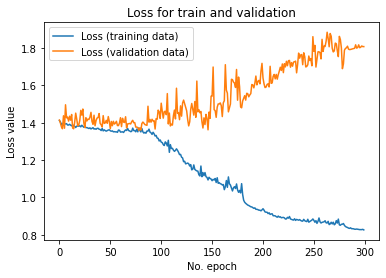

In [19]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

fig1 = plt.gcf()
plt.savefig('C:/Users/admin/Results/LSTM_Raw/13/LossAcc_13.jpg', dpi=300)
plt.show()

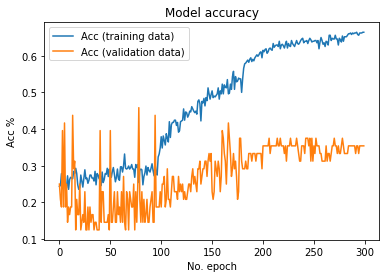

In [20]:
#Plot history: Accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

fig2 = plt.gcf()
plt.savefig('C:/Users/admin/Results/LSTM_Raw/13/ModelAcc_13.jpg', dpi=300)
plt.show()

In [21]:
# Validation score
loss,acc = model.evaluate(x_val, y_val, verbose=2)

2/2 - 1s - loss: 1.3591 - sparse_categorical_accuracy: 0.4583 - 852ms/epoch - 426ms/step


2/2 [==============================] - 2s 275ms/step


Text(0.5, 51.0, 'Predicted emotion')

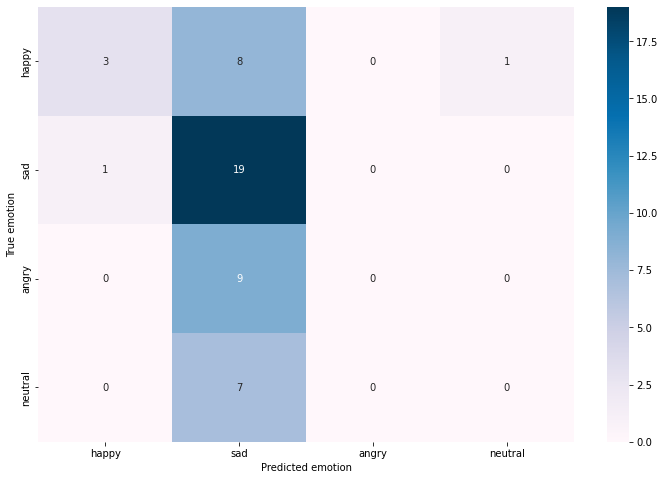

In [22]:
# Validation Confusion matrix
import pandas as pd

# Convert y_val_class into a NumPy array
y_val_class = np.array(y_val)

y_val_class = np.argmax(y_val, axis =1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val, y_pred_class)

index = ['happy', 'sad', 'angry', 'neutral']  
columns = ['happy', 'sad', 'angry', 'neutral']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [23]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
happy : 0.2500
sad : 0.9500
angry : 0.0000
neutral : 0.0000


In [24]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = 'C:/Users/admin/Results/LSTM_Raw/39/model.json'
saved_weights_path = 'C:/Users/admin/Results/LSTM_Raw/39/model_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


In [16]:
# Reading the model from JSON file

saved_model_path = 'C:/Users/admin/Results/LSTM_Raw/13/model.json'
saved_weights_path = 'C:/Users/admin/Results/LSTM_Raw/13/model_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['sparse_categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'C:/Users/admin/Results/LSTM_Raw/13/x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('C:/Users/admin/Results/LSTM_Raw/13/y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 4, dtype = 'int8')

In [27]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)

1/1 - 3s - loss: 1.3568 - sparse_categorical_accuracy: 0.3636 - 3s/epoch - 3s/step


1/1 [==============================] - 2s 2s/step


Text(0.5, 51.0, 'Predicted emotion')

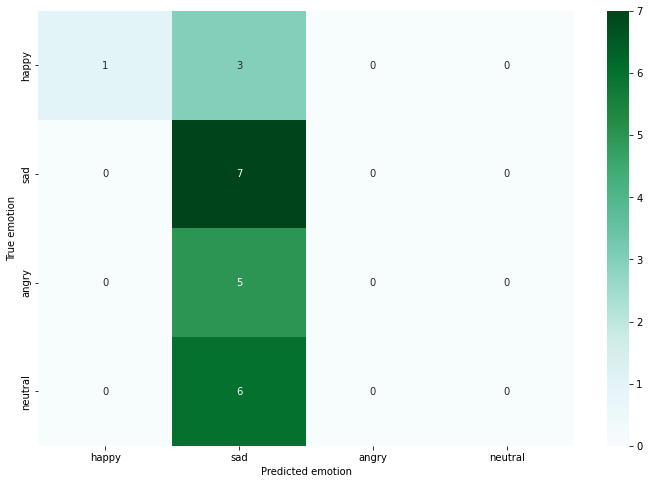

In [28]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test, y_pred_class)

index = ['happy', 'sad', 'angry', 'neutral']  
columns = ['happy', 'sad', 'angry', 'neutral']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [29]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
happy : 0.2500
sad : 1.0000
angry : 0.0000
neutral : 0.0000


In [18]:
from sklearn.metrics import classification_report


predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)
# Calculate per-emotion accuracy and other metrics
report = classification_report(y_test, y_pred_class, target_names=["happy", "sad", "angry", "neutral"], digits=2)
print("\nClassification Report:")
print(report)

1/1 [==============================] - 1s 987ms/step

Classification Report:
              precision    recall  f1-score   support

       happy       0.22      0.50      0.31         4
         sad       0.60      0.43      0.50         7
       angry       0.20      0.20      0.20         5
     neutral       0.33      0.17      0.22         6

    accuracy                           0.32        22
   macro avg       0.34      0.32      0.31        22
weighted avg       0.37      0.32      0.32        22

